## Introducción a CNNs

### Referencias
- LeCun, Y., Bengio, Y. and Hinton, G., 2015. [Deep Learning](https://www.nature.com/articles/nature14539). nature, 521(7553), pp.436-444.
- [Ignite documentation](https://pytorch-ignite.ai/)
- [PyTorch tutorials](https://pytorch.org/tutorials/) 
- [torchmetrics examples](https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html)
- [visdom](https://github.com/fossasia/visdom)


![pytorch cheatsheet](./figs/pytorch-cheat.jpeg "pytorch cheatsheet")

Figure from [pytorch forum](https://discuss.pytorch.org/t/pytorch-cheat-sheet/72016)

### Que pasos debemos seguir para entrenar una CNN?
- Cargar datos, transformarlos en formato necesario para pytorch. $t_{train}$ va a tener transformaciones diferentes a $t_{test}$, por que? 
- A los datos de entrenamiento debemos dividirlos una vez mas para usar elementos de validación durante el entrenamiento.
- Definir arquitectura de nuestra red (Ver models.py)
- Definir métodos funciones de error, optimizador y métricas de evaluación.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torchvision.transforms import Compose, Normalize, ToTensor
from sklearn.model_selection import KFold
import numpy as np
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage

### Carga de datos

In [2]:


from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import PIL

transforms_train = [
    tfs.RandomHorizontalFlip(p=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0)),
    tfs.Resize((64, 64)),
    tfs.Grayscale(1),
    tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
    tfs.ToTensor(),
]

transforms_test = [
    tfs.RandomHorizontalFlip(p=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0)),
    tfs.Resize((64, 64)),
    tfs.Grayscale(1),
    tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
    tfs.ToTensor(),
]

train_dataset = datasets.ImageFolder(
    "../data/train/", transform=tfs.Compose(transforms_train)
)

test_dataset = datasets.ImageFolder(
    "../data/test/", transform=tfs.Compose(transforms_test)
)

## Ahora tenemos que definir modelo, función de error, optimizador, etc.
- Vamos a ver como usar ignite para entrenamiento supervisado, no se olviden de ver el dashboard the visdom en [http://localhost:8097/](http://localhost:8097/)


In [3]:
import torch.optim as optim
from torch import nn
from models import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
import torch.nn.functional as F
import torch
from aux import create_plot_window
import numpy as np

In [4]:
vis = visdom.Visdom()

Setting up a new session...


### Que dispositivo tenemos disponible?

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo disponible: {device}')

Dispositivo disponible: cuda


In [6]:
def initialize():
    model = _C(input_h_w=64).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, criterion

In [7]:
def setup_dataflow(dataset, train_idx, val_idx):
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler, drop_last=True)
    val_loader = DataLoader(dataset, batch_size=64, sampler=val_sampler, drop_last=True)

    return train_loader, val_loader

In [49]:
def train_model(train_loader, val_loader, max_epochs=20):

    train_results = []
    val_results = []

    model, optimizer, criterion = initialize()

    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    evaluator = create_supervised_evaluator(model, metrics={"Accuracy": Accuracy(), "Loss": Loss(criterion)}, device=device)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics.copy()
        train_results.append(metrics)
        print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['Accuracy']:.2f} Avg loss: {metrics['Loss']:.2f}")


    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics.copy()
        val_results.append(metrics)

    trainer.run(train_loader, max_epochs=max_epochs) 

    return model, train_results, val_results

## Particionamos los datos en Train/Val

In [68]:
splits = data.random_split(train_dataset, [867, 96])
train_idx, val_idx = splits[0].indices, splits[1].indices

## Entrenamos nuestro modelo

In [69]:
train_loader, val_loader = setup_dataflow(train_dataset, train_idx, val_idx)
final_model, train_results, val_results = train_model(train_loader, val_loader, 20)

/home/pablo1n7/miniconda3/envs/cursoEsp/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training Results - Epoch[1] Avg accuracy: 0.25 Avg loss: 2.32


Engine run is terminating due to exception: 


KeyboardInterrupt: 

In [72]:
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

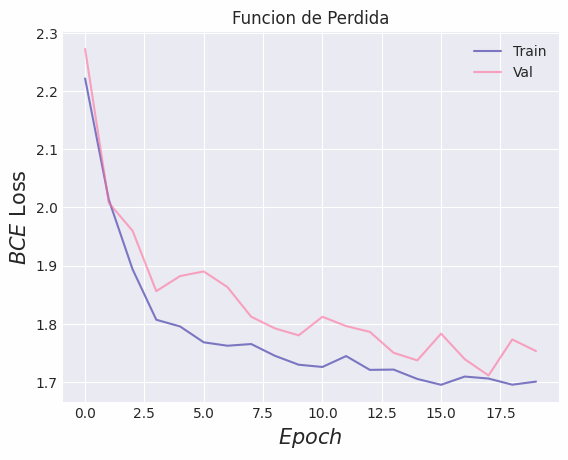

In [75]:
lossses_train = [t['Loss'] for t in train_results]
lossses_val = np.round([t['Loss'] for t in val_results], 3)

plt.plot(range(np.shape(lossses_train)[0]),lossses_train, '-', label='Train')
plt.plot(range(np.shape(lossses_val)[0]),lossses_val, '-', label='Val')
plt.title('Funcion de Perdida')
plt.xlabel('$Epoch$', fontsize=15)
plt.ylabel('$BCE$ Loss', fontsize=15)
plt.legend()

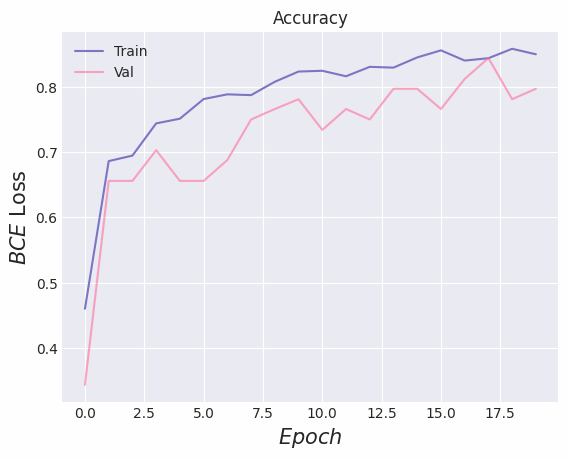

In [76]:
acc_train = [t['Accuracy'] for t in train_results]
acc_val = np.round([t['Accuracy'] for t in val_results], 3)

plt.plot(range(np.shape(acc_train)[0]),acc_train, '-', label='Train')
plt.plot(range(np.shape(acc_val)[0]),acc_val, '-', label='Val')
plt.title('Accuracy')
plt.xlabel('$Epoch$', fontsize=15)
plt.ylabel('$BCE$ Loss', fontsize=15)
plt.legend()

In [11]:
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [12]:
import torchnet

confusion_matrix = torchnet.meter.ConfusionMeter(11, normalized=True)

for ii, data_ in enumerate(test_loader):
    input_, label = data_
    val_input = input_.to(device)  # .cuda()
    val_label = label.type(torch.LongTensor).to(device)  # .cuda()
    score = final_model(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))

np.set_printoptions(precision=3)
print(confusion_matrix.conf)


[[ 7  0  0  0  0  0  0  0  0  2  0]
 [ 0 85  0  0  0  0  0  0  0  1  1]
 [ 0  0 24  0  2  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  2  1  0  8  0]
 [ 0  0  1  0 13  0  0  0  2  4  0]
 [ 0  0  1  0  0  1  1  0  0  0  0]
 [ 0  1  1  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  1  0  4  3  0  9  0]
 [ 0  1  2  0  0  0  0  0 17  0  0]
 [ 0  1  0  3  4  0  0  0  0 93  0]
 [ 0  0  1  0  0  0  0  0  0  5  0]]


In [13]:
from aux import iterations_test
from sklearn import metrics

y_real, y_pred = iterations_test(final_model, test_loader, device)
print(metrics.classification_report(np.array(y_pred), np.array(y_real)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.94      0.98      0.96        84
           2       0.92      0.77      0.84        31
           3       0.21      0.60      0.32         5
           4       0.65      0.76      0.70        17
           5       0.33      1.00      0.50         1
           6       0.94      0.68      0.79        22
           7       0.24      0.80      0.36         5
           8       0.70      0.88      0.78        16
           9       0.96      0.78      0.86       125
          10       0.50      0.60      0.55         5

    accuracy                           0.83       319
   macro avg       0.66      0.80      0.69       319
weighted avg       0.89      0.83      0.85       319



### Validación cruzada

In [ ]:
dataset = ConcatDataset([train_dataset, test_dataset])

In [ ]:
num_folds = 5
splits = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [ ]:
results_per_fold = []

for fold_idx, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold_idx + 1))

    train_loader, val_loader = setup_dataflow(dataset, train_idx, val_idx)
    train_results, val_results = train_model(train_loader, val_loader)
    results_per_fold.append([train_results, val_results])

In [ ]:
acc_sum = 0
for n_fold in range(len(results_per_fold)):
  current_fold = results_per_fold[n_fold]
  print(f"Validation Results - Fold[{n_fold + 1}] Avg accuracy: {current_fold[1][2]['Accuracy']:.2f} Avg loss: {current_fold[1][2]['Loss']:.2f}")
  acc_sum += current_fold[1][2]['Accuracy']

folds_mean = acc_sum/num_folds
print(f"Model validation average for {num_folds}-folds: {folds_mean :.2f}")

###  Ejercicios

- Visualizar las funciones de perdida para distintos learning rates. Qué observan en los gráficos?
- Visualizar las funciones de perdida para distintos tamanos de lotes. 
- Visualizar un grupo de elementos del grupo de evaluacion con la clasificación y su puntaje respectivo.
- Comparar metricas de red entrenada en 10, 50 y 100 epochs. Qué diferencias observan?
- Re-entrenar un modelo preentrando `from torchvision import  models` para clasificacion, comparar sus resultados.